In [24]:
import utils
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

 # Exercise 2

The solution is given using the matrix formalism.

## II.1 Polynomial fitting

1. Implement $f(x, w) = \Phi^\top w$. First implement $\Phi$ as:

In [25]:
def Phi_f(x, d):
    """Computes the feature matrix [ x^0 x^1 ... x^d ]^T
    x: (N,) samples
    d: exponent to use
    Output:
        (d+1)xN matrix
        """
    return x.reshape(1, -1) ** np.arange(d+1).reshape(-1, 1)

then $f$:

In [26]:
def f(x, w):
    """Compute the features
    x: (N,) vector of samples
    w: (d+1,) vector of weights
    Output:
        N vector
        """
    d = w.shape[0] -1
    Phi = Phi_f(x, d)  # the exponents of x, size d+1 x N
    y = Phi.T @ w  # of size N,
    return y

2. Implement $E_\lambda(w)$

In [27]:
def  E(w, lmbda, x, t):
    """Energy function E_\lambda, vectorized
    w: (d,)
    x: (N,d)
    t: (N,)
    """
    y = f(x, w)  # (N,)
    return 1/2*np.linalg.norm(y - t)**2 + lmbda/2 * np.linalg.norm(w)^2

In [28]:
# and $\nabla E_\lambda(w)$
def grad_E(w, lmbda, x, t):
    """Gradient of E
    w: (d+1,)
    x: (N,)
    t: (N,)
    """
    d = w.shape[0]-1
    Phi = Phi_f(x, d)
    I = np.eye(d)
    return Phi @(Phi.T @ w - t) + lmbda*w

3.a. Gradient descent steps to minimize $E$.

In [29]:
def find_w_GD(w0,  lmbda, x, t, eta=0.1, tol=1e-3, MAX_STEP=10_000):
    """Find the optimal w with gradient descent
    w0: (d+1,) starting point
    x: (N,) samples
    t: (N,) targets
    tol: tolerance as stoppping criterion
    Output:
        w* optimal
    """
    k = 0
    converged = False
    w = w0
    while not converged:
        grad = grad_E(w, lmbda, x, t)
        w = w - eta * grad
        converged = np.linalg.norm(grad) < tol or k > MAX_STEP
        k += 1
    return w, k

3.b Find $w^*$ by solving the linear system, $w^* = (\Phi \Phi^\top + \lambda
I)^{-1} \Phi t$

In [30]:
def find_w_sys(lmbda, x, t, d):
    """Find the optimal w by solving the system of linear equations
    x: (N,) samples
    t: (N,) targets
    d: degree of the polynomial
    """
    I = np.eye(d+1)
    Phi = Phi_f(x, d)
    Inv = sp.linalg.inv(Phi @ Phi.T + lmbda* I)
    return Inv @ Phi @ t

Plot the different results

In [42]:
# Fixed N, varying lambda, d
Ds = [1, 3, 9, 15]  # will serve as row index
lambdas = [0, 0.01, 0.1, 1]  # column index
N = 30  # number of samples
eta = 0.01  # learning rate

In [43]:
np.random.seed(1)

In [ ]:
Nrow = len(Ds)
Ncol = len(lambdas)
x, t = utils.gen_sin_data(N=N)  # training samples, N points
fig, axes = plt.subplots(Nrow, Ncol, figsize=(Ncol*4, Nrow*4))
for iD, d in enumerate(Ds):
    for il, lmbda in enumerate(lambdas):


        ax = axes[iD,il]
        w0 = np.zeros(d+1)  # y=0, starting point for GD
        w_GD, nsteps = find_w_GD(w0, lmbda, x, t, eta=eta)  # solution from GD

        w_sys = find_w_sys(lmbda, x, t, d)  # solution from solving linear system

        xtest = np.linspace(min(x),max(x))
        ytest_GD = f(xtest, w_GD)
        ytest_sys = f(xtest, w_sys)

        ax.scatter(x, t, label='samples')
        ax.plot(xtest, ytest_GD, color='orange', label=f"GD ({nsteps} iter)")
        ax.plot(xtest, ytest_sys, color='red', label="Sol. system")
        ax.legend()
        ax.set_title(f"$\lambda={lmbda}, d={d}$")

In [34]:
fig.suptitle(f"N = {N}")
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

**Questions:** 1.What happens when $d+1> N$? When $N \gg 1$?

2.What can go wrong with the linear system solution? With the gradient
solution?

**Answers** 1. We also have $\mathrm{rank}(\Phi \Phi^\top) =
\mathrm{rank}(\Phi) \leqslant \min(d+1, N)$. We also know that $\Phi
\Phi^\top$ is invertible if and only if $\mathrm{rank}(\Phi \Phi^\top) = d+1$.
When $d+1>N$, the matrix $\Phi \Phi^\top$ is therefore not invertible (SciPy raises a LinalgError("singular matrix") when $\lambda =0$).
This illustrates that there are more than one solution to the fitting problem.

In [35]:
d = 30
N = 3
lmbda = 0

In [36]:
w0 = np.zeros(d+1)  # y=0, starting point for GD
x, t = utils.gen_sin_data(N=N)  # training samples, N points

In [37]:
try:
    w_sys = find_w_sys(lmbda, x, t, d)  # solution from solving linear system
except sp.LinAlgError:
    print("Non invertible matrix")

When $N \gg 1$, and $N > D+1$, there are more points than  dimensions and
therefore, even if the matrix $\Phi \Phi^\top$ is invertible,  the solution
found won't have 0 training error (no interpolation). The solution with lowest
training error is nonetheless selected. 
Running GD with $N\gg 1$ can lead to unstability if the learning rate is not
scaled down.

In [38]:
Ds = [1, 3, 9, 15]  # will serve as row index
lambdas = [0, 0.01, 0.1, 1]  # column index
N = 300  # number of samples, >> 1
eta = 0.001  # learning rate

In [39]:
np.random.seed(1)

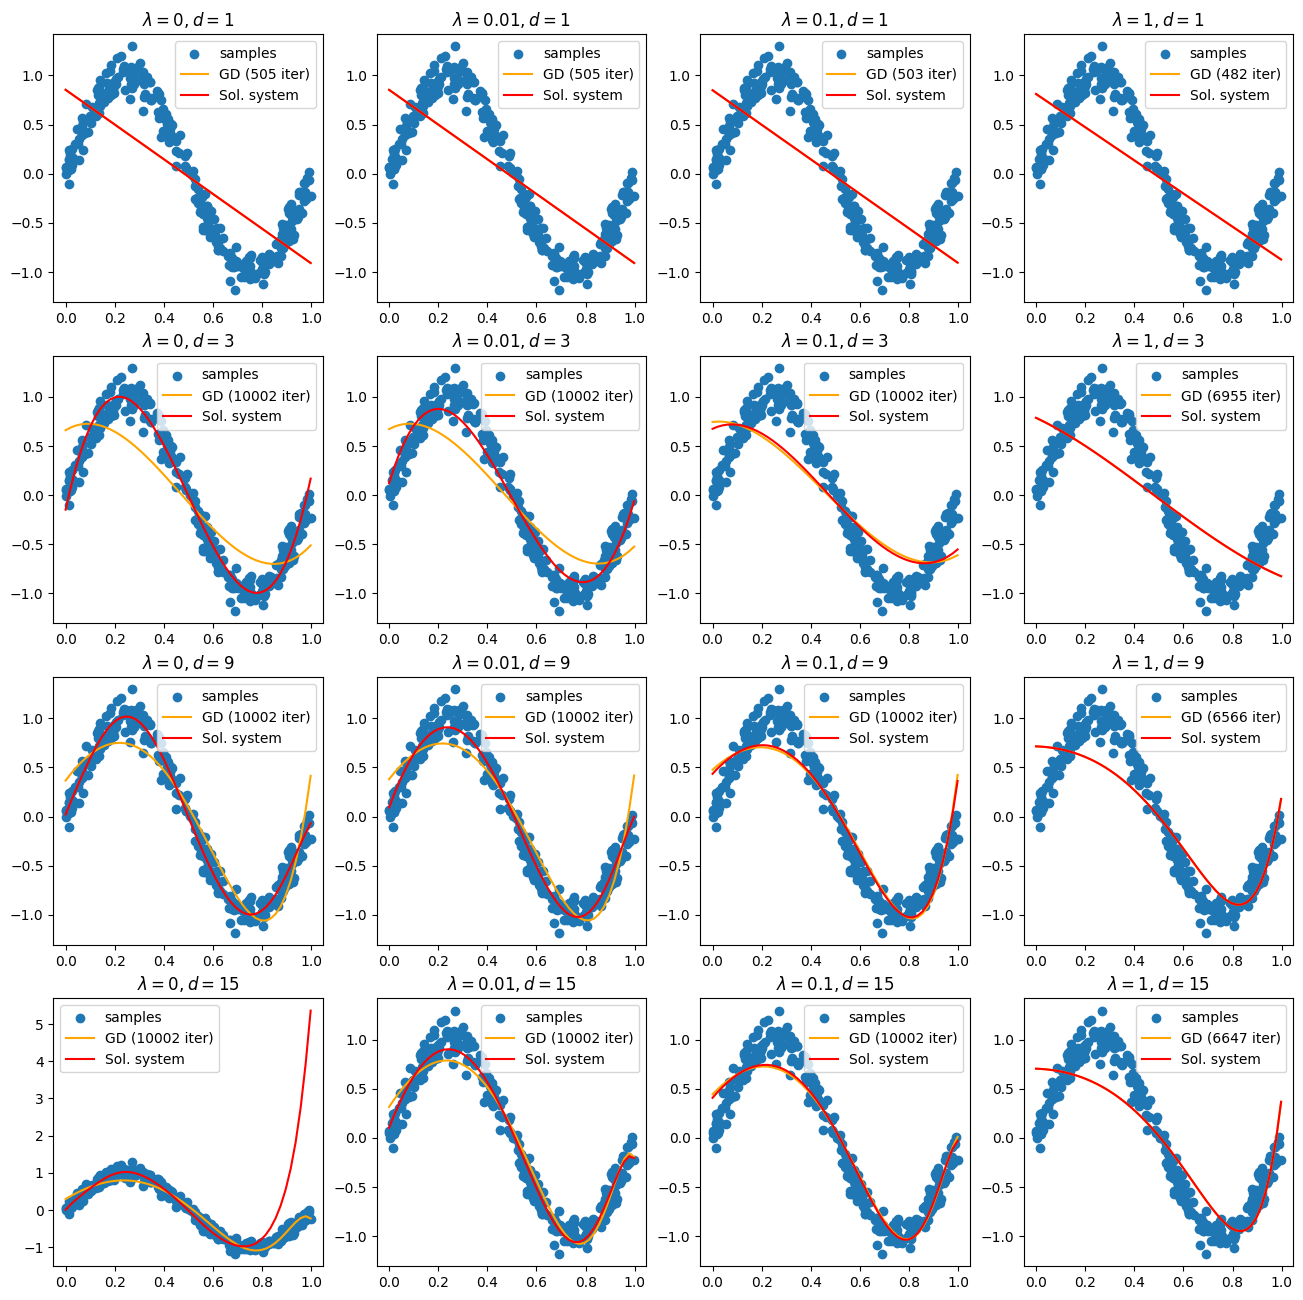

In [40]:
Nrow = len(Ds)
Ncol = len(lambdas)
x, t = utils.gen_sin_data(N=N)  # training samples, N points
fig, axes = plt.subplots(Nrow, Ncol, figsize=(Ncol*4, Nrow*4))
for iD, d in enumerate(Ds):
    for il, lmbda in enumerate(lambdas):


        ax = axes[iD,il]
        w0 = np.zeros(d+1)  # y=0, starting point for GD
        w_GD, nsteps = find_w_GD(w0, lmbda, x, t, eta=eta)  # solution from GD

        w_sys = find_w_sys(lmbda, x, t, d)  # solution from solving linear system

        xtest = np.linspace(min(x),max(x))
        ytest_GD = f(xtest, w_GD)
        ytest_sys = f(xtest, w_sys)

        ax.scatter(x, t, label='samples')
        ax.plot(xtest, ytest_GD, color='orange', label=f"GD ({nsteps} iter)")
        ax.plot(xtest, ytest_sys, color='red', label="Sol. system")
        ax.legend()
        ax.set_title(f"$\lambda={lmbda}, d={d}$")

In [41]:
fig.suptitle(f"N = {N}")
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

3.How to correct these issues?

The non invertibility issue can be corrected by adding a regularizer, or using
the pseudo inverse insted of the inverse (also selects the solution with least
squared parameter norm).
In the case of $N \gg 1$, the learning rate has to be reduced or a mean should
be computed in the energy.
